In [1]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import mediapipe as mp
from deepface import DeepFace
import subprocess
import collections
import webrtcvad
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# --- Funcții VAD (voice activity detection) ---

In [ ]:
# Extrage audio dintr-un fișier video folosind ffmpeg
def extract_audio_ffmpeg(video_path, audio_output_path='temp_audio.wav'):
    command = [
        'ffmpeg',
        '-y',
        '-i', video_path,
        '-vn',
        '-acodec', 'pcm_s16le',
        '-ar', '16000',
        '-ac', '1',
        audio_output_path
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
# Genereaza framuri dintr-un video
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    while offset + n < len(audio):
        yield audio[offset:offset + n]
        offset += n

In [4]:
def vad_collector(sample_rate, frame_duration_ms,
                  padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    triggered = False
    voiced_frames = []
    segments = []
    start_time = 0
    frame_index = 0
    for frame in frames:
        is_speech = vad.is_speech(frame, sample_rate)
        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, speech in ring_buffer if speech])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                start_time = frame_index * frame_duration_ms / 1000.0
                voiced_frames.extend([f for f, s in ring_buffer])
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, speech in ring_buffer if not speech])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                end_time = frame_index * frame_duration_ms / 1000.0
                segments.append((start_time, end_time))
                ring_buffer.clear()
                voiced_frames = []
        frame_index += 1

    if triggered:
        segments.append((start_time, frame_index * frame_duration_ms / 1000.0))
    return segments

In [ ]:
# Extrage segmentele de vorbire dintr-un fișier audio folosind WebRTC VAD
def extract_speech_segments(audio_path):
    with open(audio_path, 'rb') as f:
        audio = f.read()
    sample_rate = 16000
    vad = webrtcvad.Vad(1)
    
    frames = list(frame_generator(30, audio, sample_rate))
    segments = vad_collector(sample_rate, 30, 300, vad, frames)
    return segments

# Functii de calcul scor lip-movment

In [ ]:
# Calculeaza un scor pentru mișcarea buzelor
def lip_movement_score(landmarks, prev_landmarks, frame_shape):
    lips_ids = [61, 291, 13, 14, 17, 0, 37, 267]
    anchor_ids = [1, 33, 263, 168, 2]  # puncte fixe: nas și colțuri ochi

    if landmarks is None or prev_landmarks is None:
        return 0

    # Extrage pozițiile actuale și anterioare pentru buze și ancore
    current_lips = np.array([(landmarks.landmark[i].x * frame_shape[1],
                              landmarks.landmark[i].y * frame_shape[0]) for i in lips_ids])
    prev_lips = np.array([(prev_landmarks.landmark[i].x * frame_shape[1],
                           prev_landmarks.landmark[i].y * frame_shape[0]) for i in lips_ids])

    current_anchors = np.array([(landmarks.landmark[i].x * frame_shape[1],
                                 landmarks.landmark[i].y * frame_shape[0]) for i in anchor_ids])
    prev_anchors = np.array([(prev_landmarks.landmark[i].x * frame_shape[1],
                              prev_landmarks.landmark[i].y * frame_shape[0]) for i in anchor_ids])

    # Calculează centrul de masă al punctelor de referință (ancore)
    current_center = np.mean(current_anchors, axis=0)
    prev_center = np.mean(prev_anchors, axis=0)

    # Compensează translația capului (mișcarea globală)
    corrected_lips = current_lips - (current_center - prev_center)

    # Distanța efectivă a buzelor (după corectarea mișcării capului)
    dist = np.linalg.norm(corrected_lips - prev_lips)
    return dist

# Calculează variația deschiderii buzelor
def lip_opening_variation(landmarks, prev_landmarks, frame_shape):
    if landmarks is None or prev_landmarks is None:
        return 0

    # Punctele cheie (centru gurii)
    top_id = 13
    bottom_id = 14

    # Coordonate actuale
    top = np.array([landmarks.landmark[top_id].x * frame_shape[1],
                    landmarks.landmark[top_id].y * frame_shape[0]])
    bottom = np.array([landmarks.landmark[bottom_id].x * frame_shape[1],
                       landmarks.landmark[bottom_id].y * frame_shape[0]])

    # Coordonate anterioare
    prev_top = np.array([prev_landmarks.landmark[top_id].x * frame_shape[1],
                         prev_landmarks.landmark[top_id].y * frame_shape[0]])
    prev_bottom = np.array([prev_landmarks.landmark[bottom_id].x * frame_shape[1],
                            prev_landmarks.landmark[bottom_id].y * frame_shape[0]])

    # Distanțele verticale între buze (actual vs anterior)
    current_distance = np.linalg.norm(top - bottom)
    prev_distance = np.linalg.norm(prev_top - prev_bottom)

    # Diferența de deschidere gură
    return abs(current_distance - prev_distance)

# Calculează un scor combinat pentru mișcarea buzelor
def combined_lip_movement_score(landmarks, prev_landmarks, frame_shape, alpha=0.7):
    movement = lip_movement_score(landmarks, prev_landmarks, frame_shape)
    opening_change = lip_opening_variation(landmarks, prev_landmarks, frame_shape)
    return alpha * opening_change + (1 - alpha) * movement



# Functii utile pentru video + testare video

In [ ]:
# Da play video și evidențiază vorbitorul
def play_video_with_face_highlight(video_path, face_positions_per_frame, speaker_id, fps, face_ids_per_frame):
    frame_count = len(face_positions_per_frame)

    while True:  # loop infinit
        cap = cv2.VideoCapture(video_path)
        frame_idx = 0

        while frame_idx < frame_count:
            ret, frame = cap.read()
            if not ret:
                break

            positions = face_positions_per_frame[frame_idx]
            ids = face_ids_per_frame[frame_idx]

            for bbox, person_id in zip(positions, ids):
                x1, y1, x2, y2 = map(int, bbox)
                color = (0, 255, 0) if person_id == speaker_id else (255, 0, 0)  # verde = vorbitor
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

                if person_id != -1:
                    label = f"ID {person_id}"
                    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

            cv2.imshow('Speaker Detection', frame)
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()
                return  # ieșire din loop dacă apeși 'q'

            frame_idx += 1

        cap.release()


In [ ]:
# Obtine bounding box-ul feței din landmarks
def get_face_bounding_box(landmarks, frame_shape):
    x_coords = [landmarks.landmark[i].x * frame_shape[1] for i in range(len(landmarks.landmark))]
    y_coords = [landmarks.landmark[i].y * frame_shape[0] for i in range(len(landmarks.landmark))]
    x_min, x_max = int(min(x_coords)), int(max(x_coords))
    y_min, y_max = int(min(y_coords)), int(max(y_coords))
    return x_min, y_min, x_max, y_max

# Functii de analiza video

In [ ]:
# Functia analizaeaza un video pentru a detecta vorbitorii și mișcarea buzelor, oferind detali despre vorbitorul principal
def analyze_video(video_path, speech_segments, face_mesh, lip_movement_threshold=15, verbose=False):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    frame_idx = 0
    lip_movement_scores = {}
    prev_landmarks_dict = {}
    face_positions_per_frame = []
    face_ids_per_frame = []
    full_frames = []

    known_embeddings = []
    known_ids = []
    next_id = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        full_frames.append(frame.copy())
        time_sec = frame_idx / fps
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        if not results.multi_face_landmarks:
            face_positions_per_frame.append([])
            face_ids_per_frame.append([])
            frame_idx += 1
            continue

        speaking = any(start <= time_sec <= end for (start, end) in speech_segments)
        current_frame_positions = []
        current_frame_ids = []

        for face_landmarks in results.multi_face_landmarks:
            # Bounding box
            bbox = get_face_bounding_box(face_landmarks, frame.shape)
            x_min, y_min, x_max, y_max = map(int, bbox)

            # Crop and preprocess face
            face_crop = rgb_frame[y_min:y_max, x_min:x_max]
            if face_crop.size == 0:
                current_frame_positions.append(bbox)
                current_frame_ids.append(-1)
                continue

            try:
                embedding_obj = DeepFace.represent(face_crop, model_name='Facenet', enforce_detection=False)
                embedding = np.array(embedding_obj[0]['embedding'])
            except Exception as e:
                if verbose:
                    print(f"Embedding extraction failed at frame {frame_idx}: {e}")
                current_frame_positions.append(bbox)
                current_frame_ids.append(-1)
                continue

            person_id = -1
            if known_embeddings:
                sims = cosine_similarity([embedding], known_embeddings)[0]
                best_idx = np.argmax(sims)
                if sims[best_idx] > 0.6:
                    person_id = known_ids[best_idx]

            if person_id == -1:
                person_id = next_id
                next_id += 1
                known_embeddings.append(embedding)
                known_ids.append(person_id)
                lip_movement_scores[person_id] = 0
                prev_landmarks_dict[person_id] = None

            move = combined_lip_movement_score(face_landmarks, prev_landmarks_dict[person_id], frame.shape)
            if move > lip_movement_threshold:
                move = 0

            prev_landmarks_dict[person_id] = face_landmarks
            if speaking:
                lip_movement_scores[person_id] += move
                if verbose:
                    print(f"Frame {frame_idx}, ID {person_id}, Score: {lip_movement_scores[person_id]:.2f}, move: {move:.2f}")

            current_frame_positions.append(bbox)
            current_frame_ids.append(person_id)

        face_positions_per_frame.append(current_frame_positions)
        face_ids_per_frame.append(current_frame_ids)
        frame_idx += 1

    cap.release()

    sorted_ids = sorted(lip_movement_scores.keys())
    scores = [lip_movement_scores[i] for i in sorted_ids]

    if not scores:
        return scores, face_positions_per_frame, fps, video_path, face_ids_per_frame, []

    # Extrage crop-urile fetei vorbitorului principal
    main_speaker_id = sorted_ids[np.argmax(scores)]
    main_speaker_crops = []

    for frame, bboxes, ids in zip(full_frames, face_positions_per_frame, face_ids_per_frame):
        for bbox, pid in zip(bboxes, ids):
            if pid == main_speaker_id:
                x1, y1, x2, y2 = map(int, bbox)
                crop = frame[y1:y2, x1:x2]
                if crop.size > 0:
                    main_speaker_crops.append(crop)

    return scores, face_positions_per_frame, fps, video_path, face_ids_per_frame, main_speaker_crops


# Functii de detectare emoti

In [ ]:
# Prezice emotia cu deepface
def predict_emotion(frame):
    result = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
    return result[0]['dominant_emotion']

In [ ]:
# Prezice emotia din video pentru vorbitorul principal folosind analiza video si functia predict_emotion
def predict_emotions_in_video_for_speaker(video_path, face_mesh, plot_faces=False, frame_skip = 5, verbose=False):
    audio_path = 'temp_audio.wav'

    extract_audio_ffmpeg(video_path, audio_path)
    speech_segments = extract_speech_segments(audio_path)
    
    scores, positions, fps, path, ids_per_frame, crops = analyze_video(video_path, speech_segments, face_mesh, lip_movement_threshold=10, verbose=True)

    vorbitoarea_index = np.argmax(scores)

    if verbose:    
        print("Lip movement scores pentru fiecare față:", scores)
        print(f"Persoana care vorbește cel mai probabil este fața cu indexul: {vorbitoarea_index}")

    
    if not crops:
        print("Nu s-a găsit niciun frame valid cu fața persoanei ce vorbeste.")
        return None
    elif verbose:
        print(f"Numărul de frame-uri valide cu fața vorbitoarei: {len(crops)}")

    emotions = []

    for i in range(0, len(crops), frame_skip):
        if( plot_faces ):
            plt.imshow(crops[i])
            plt.title(f"Fața vorbitoarei la frame {i}")
            plt.axis('off')
            plt.show()

        # Predicție emoție
        emotions.append(predict_emotion(crops[i]))

    audio_path = Path(audio_path)
    if audio_path.exists():
        audio_path.unlink() 

    result = {
        'video_path': path,
        'scores': scores,
        'emotions': emotions,
        'face_positions_per_frame': positions,
        'fps': fps,
        'face_ids_per_frame': ids_per_frame,
        'main_speaker_crops': crops
    }

    return result

# Configurare Face-Mesh

In [12]:
mp_face_mesh = mp.solutions.face_mesh
# face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=5)

face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,            # False e mai rapid, face tracking între frame-uri
    max_num_faces=4,                    # Numărul maxim de fețe de detectat
    refine_landmarks=True,              # Detectează și puncte suplimentare pe buze, ochi (utile pt mișcare buze)
    min_detection_confidence=0.4,      # Pragul pentru detectare; mai mic = mai sensibil, dar posibil mai multe false positive
    min_tracking_confidence=0.6        # Pragul pentru tracking; mai mic = detectare mai tolerantă la pierderea feței între frame-uri
)

# Exemple rulare

In [ ]:
path = Path.cwd().parent.parent

# path = path / 'data' / 'dev' / 'dev_splits_complete' / 'dia1_utt9.mp4' #o singura persoana barbat pozitie clara
path = path / 'data' / 'dev' / 'dev_splits_complete' / 'dia0_utt0.mp4' #3 persoane, pozitie clara vorbeste o singura persoana din dreapta

Frame 7, ID 0, Score: 0.53, move: 0.53
Frame 8, ID 0, Score: 0.95, move: 0.43
Frame 9, ID 0, Score: 1.49, move: 0.54
Frame 10, ID 0, Score: 2.34, move: 0.85
Frame 11, ID 0, Score: 2.60, move: 0.26
Frame 12, ID 0, Score: 3.01, move: 0.41
Frame 13, ID 0, Score: 3.20, move: 0.19
Frame 14, ID 0, Score: 3.47, move: 0.27
Frame 15, ID 0, Score: 3.85, move: 0.37
Frame 16, ID 0, Score: 4.26, move: 0.41
Frame 17, ID 0, Score: 4.69, move: 0.43
Frame 18, ID 0, Score: 4.95, move: 0.26
Frame 19, ID 0, Score: 11.04, move: 6.09
Frame 19, ID 0, Score: 17.11, move: 6.07
Frame 20, ID 0, Score: 17.63, move: 0.52
Frame 21, ID 0, Score: 17.93, move: 0.30
Frame 22, ID 0, Score: 17.93, move: 0.00
Frame 22, ID 0, Score: 17.93, move: 0.00
Frame 23, ID 0, Score: 18.18, move: 0.25
Frame 24, ID 1, Score: 0.00, move: 0.00
Frame 24, ID 0, Score: 18.61, move: 0.43
Frame 25, ID 1, Score: 4.46, move: 4.46
Frame 25, ID 0, Score: 18.85, move: 0.24
Frame 26, ID 1, Score: 5.71, move: 1.25
Frame 26, ID 0, Score: 19.35, move

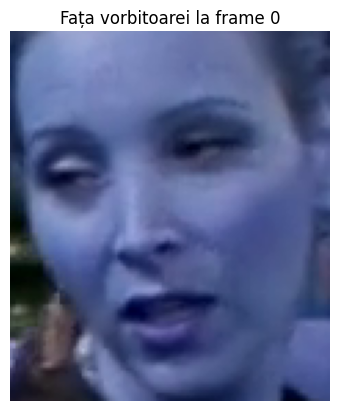

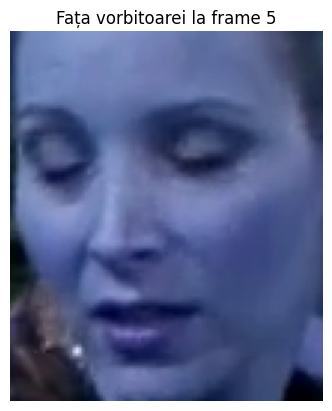

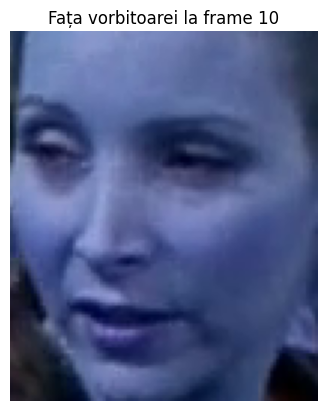

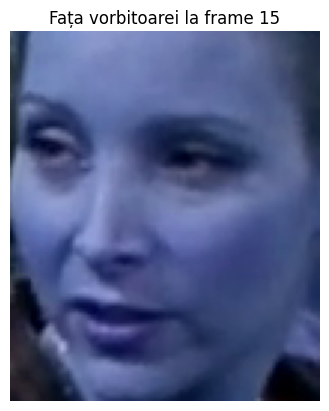

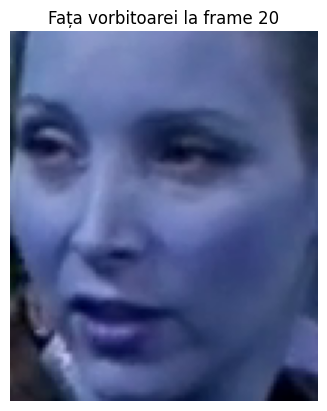

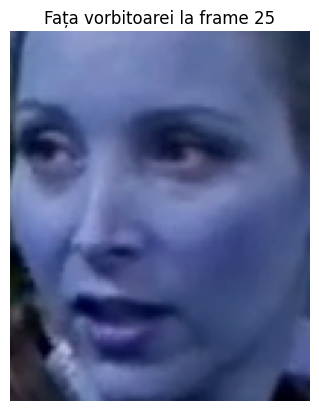

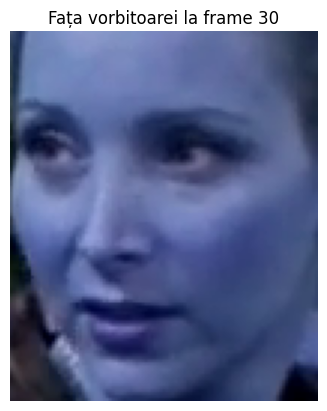

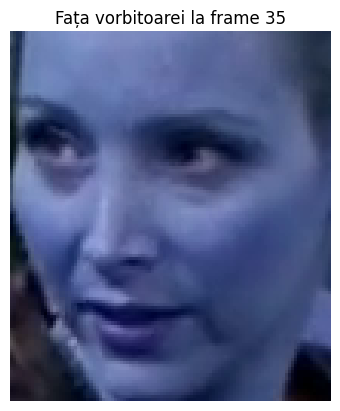

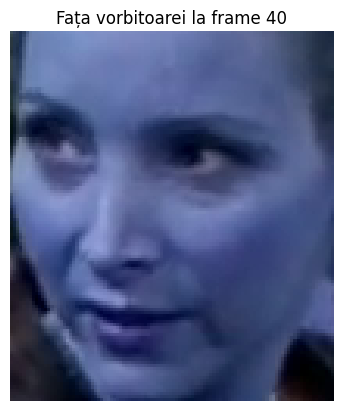

In [14]:
res = predict_emotions_in_video_for_speaker(path, face_mesh=face_mesh, plot_faces=True, frame_skip=5, verbose=True)

[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0, 0], [0], [0], [0, 0], [0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 2], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [3, 4]]
Lip movement scores pentru fiecare față: [40.473832267033686, 54.53044154971114, 0.0, 0.0, 0.0]
Vorbitorul cu ID 1 a avut cel mai mare scor de mișcare a buzelor: 54.53


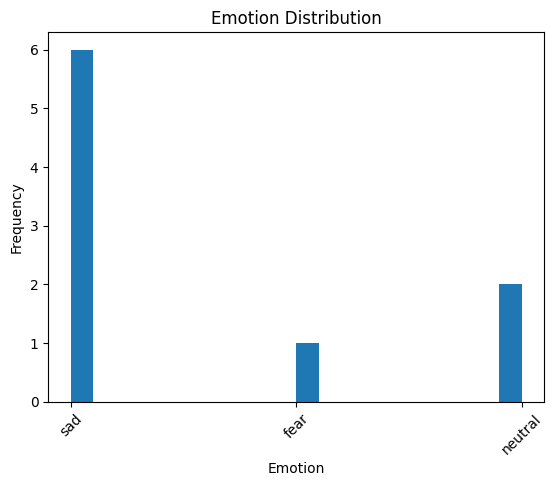

In [15]:
print(res["face_ids_per_frame"])
print("Lip movement scores pentru fiecare față:", res["scores"])

vorbitoarea_index = np.argmax(res["scores"])  # ID-ul feței care a vorbit cel mai mult

print(f"Vorbitorul cu ID {vorbitoarea_index} a avut cel mai mare scor de mișcare a buzelor: {res["scores"][vorbitoarea_index]:.2f}")

play_video_with_face_highlight(res["video_path"], res["face_positions_per_frame"], vorbitoarea_index, res["fps"], res["face_ids_per_frame"])

plt.hist(res["emotions"], bins=20)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.title('Emotion Distribution')
plt.xticks(rotation=45)
plt.show()